In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [23]:
class NeuralNetwork:
    def __init__(self, inputSize, outputSize, hiddenLayers, learningRate, decay):
        self.layerSizes = [inputSize] + hiddenLayers + [outputSize]
        self.learningRate = learningRate
        self.decay = decay

        self.weights = []
        self.biases = []

        self.intermediateValues = []
        self.activationValues = []

        self.weightAdjustments = []
        self.biasAdjustments = []

        self.iterations = 0

        #Initialise connections between the input layer, the hidden layers and the output layer
        for i in range(len(self.layerSizes) - 1):
            self.weights.append(np.random.default_rng().standard_normal((self.layerSizes[i],self.layerSizes[i+1])))
            self.biases.append(np.zeros((1,self.layerSizes[i+1])))

    def forward(self, inputs):

        #Rectified linear unit function for non-linearity
        def ReLU(x):
            return np.maximum(0, x)
    
        #Softmax function converts the final results into a probability distribution
        def softmax(x):
            eX = np.exp(x - np.max(x, axis=1, keepdims=True))
            return eX/np.sum(eX, axis=1, keepdims=True) #apply softmax to each of the results individually but keep all the dimensions
        
        self.activationValues = [inputs]
        self.intermediateValues = []

        for i in range(len(self.weights)):
            z = np.dot(self.activationValues[-1],self.weights[i]) + self.biases[i]
            self.intermediateValues.append(z)

            if (i < len(self.weights) - 1):
                #ReLU applied to values of every layer but the last
                self.activationValues.append(ReLU(z))
            else:
                #Softmax function applied to the last layer
                self.activationValues.append(softmax(z))

        return self.activationValues[-1]
            
    def backward(self, encodedLabels):

        def dReLU(x):
            return x > 0
        
        outputs = self.activationValues[-1].copy()
        numberOfOutputs = len(outputs)
        #difference between predicted results and wanted results
        outputs = outputs - encodedLabels
        outputs = outputs / numberOfOutputs

        #partial derivative of cost with respect to weights
        dWeights = np.dot(self.activationValues[-2].T, outputs.copy())

        #partial derivative of cost with respect to biases
        dBiases = np.sum(outputs.copy(), axis=0, keepdims=True)

        #partial derivative of cost with respect to inputs into final layer
        dInput = np.dot(outputs.copy(), self.weights[-1].T)

        self.weightAdjustments = [dWeights]
        self.biasAdjustments = [dBiases]

        for i in range(len(self.layerSizes) - 3, -1, -1):

            dInputRelu = dInput * dReLU(self.intermediateValues[i])
            dWeights = np.dot(self.activationValues[i].T, dInputRelu)
            dBiases = np.sum(dInputRelu, axis=0, keepdims=True)
            dInput = np.dot(dInputRelu, self.weights[i].T)

            self.weightAdjustments.insert(0, dWeights)
            self.biasAdjustments.insert(0, dBiases)       

    def gradientDescent(self, inputs, labels, batchSize, epochs):
        accuracies = []
        losses = []

        def logOutputs():
            predictions = self.getPredictions(outputs)
            accuracy = self.getAccuracy(predictions, batchLabels)
            accuracies.append(accuracy)

            loss = self.getMeanLoss(outputs,encodedLabels)
            losses.append(loss)
            
            print(f"Epoch: {epoch}, Accuracy: {accuracy:.3f}, Loss: {loss:.3f}")

        def graphOutputs():
            plt.plot([i for i in range(len(accuracies))], accuracies, label = "Accuracy")
            plt.plot([i for i in range(len(losses))], losses, label = "Loss")

            plt.xlabel("Batch Number")
            plt.legend()

            plt.show()

        for epoch in range(epochs):
            print("Starting epoch", epoch)
            trainSteps = len(inputs) // batchSize

            for step in range(trainSteps):
                batchInputs = inputs[step * batchSize : (step + 1) * batchSize]
                batchLabels = labels[step * batchSize : (step + 1) * batchSize]

                encodedLabels = self.oneHotEncode(batchLabels)

                outputs = self.forward(batchInputs)
                
                if step % 100 == 0:
                    logOutputs()

                self.backward(encodedLabels)
                self.updateWeightsBiases()

        graphOutputs()
    
    def updateWeightsBiases(self):
        currentRate = self.learningRate / (1. + self.decay * self.iterations)

        for i in range(len(self.weights)):
            self.weights[i] += -currentRate * self.weightAdjustments[i]
            self.biases[i] += -currentRate * self.biasAdjustments[i]

        self.iterations += 1  

    def getMeanLoss(self, outputs, encodedLabels):
            outputs = np.clip(outputs, 1e-10, 1 - 1e-10) #Prevents log(0) if the output contains 0 by keeping values in range
            loss = -np.sum(encodedLabels * np.log(outputs), axis=1) #Calculates cross categorical entropy loss
            return np.mean(loss)

    def getPredictions(self, outputs):
        return np.argmax(outputs, 1) #The highest value in the output layer has the same index as the predicion

    def getAccuracy(self, predictions, labels):
        return np.mean(predictions == labels)

    def oneHotEncode(self, inputs):
        numberOfClasses = self.layerSizes[-1] #The final layer is the number of outputs which is the number of classes
        encodedLabels = np.zeros((len(inputs), numberOfClasses)) #Create an array of 0s for every input
        encodedLabels[np.arange(len(inputs)), inputs] = 1 #Change the (current input)th 0 value to a 1 in every array (arange iterates over the arrays of 0)
        return encodedLabels

# MNIST classification

In [24]:
data = pd.read_csv('archive/mnist_train.csv')

data = np.array(data)
np.random.default_rng().shuffle(data)

#Get the labels (stored in column 0) and store them in an array
trainingLabels = data[:, 0]
#Get the rest of the data
trainingData = data[:,1:]
#Convert the integer values 0 - 255 to float values 0 - 1
trainingData = (trainingData.astype(np.float32))/255


Starting epoch 0
Epoch: 0, Accuracy: 0.033, Loss: 21.863
Epoch: 0, Accuracy: 0.700, Loss: 4.740
Epoch: 0, Accuracy: 0.767, Loss: 4.257
Epoch: 0, Accuracy: 0.833, Loss: 1.300
Epoch: 0, Accuracy: 0.800, Loss: 2.979
Epoch: 0, Accuracy: 0.800, Loss: 2.816
Epoch: 0, Accuracy: 0.800, Loss: 3.426
Epoch: 0, Accuracy: 0.800, Loss: 1.524
Epoch: 0, Accuracy: 0.700, Loss: 3.579
Epoch: 0, Accuracy: 0.900, Loss: 0.750
Epoch: 0, Accuracy: 0.867, Loss: 1.550
Epoch: 0, Accuracy: 0.867, Loss: 1.810
Epoch: 0, Accuracy: 0.900, Loss: 1.868
Epoch: 0, Accuracy: 0.867, Loss: 0.969
Epoch: 0, Accuracy: 0.867, Loss: 0.888
Epoch: 0, Accuracy: 0.833, Loss: 0.323
Epoch: 0, Accuracy: 0.900, Loss: 1.068
Epoch: 0, Accuracy: 0.767, Loss: 1.473
Epoch: 0, Accuracy: 0.867, Loss: 1.483
Epoch: 0, Accuracy: 0.833, Loss: 1.501
Starting epoch 1
Epoch: 1, Accuracy: 0.800, Loss: 2.551
Epoch: 1, Accuracy: 0.967, Loss: 0.062
Epoch: 1, Accuracy: 0.867, Loss: 1.348
Epoch: 1, Accuracy: 0.867, Loss: 0.687
Epoch: 1, Accuracy: 0.900, Lo

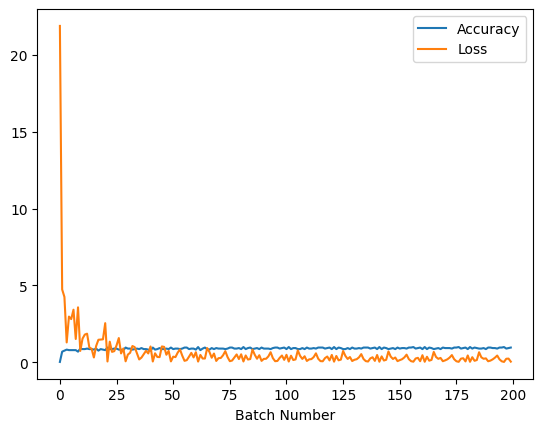

In [25]:
mnistNeuralNetwork = NeuralNetwork(784, 10, [100], 0.05, 1e-7)
mnistNeuralNetwork.gradientDescent(trainingData, trainingLabels, 30, 10)


In [26]:
testData = pd.read_csv('archive/mnist_test.csv')

data = np.array(data)
np.random.default_rng().shuffle(data)

#Get the labels (stored in column 0) and store them in an array
testLabels = data[:, 0]
#Get the rest of the data
testData = data[:,1:]
#Convert the integer values 0 - 255 to float values -1 - 1
testData = (testData.astype(np.float32))/255

In [27]:
output = mnistNeuralNetwork.forward(testData)
predictions = mnistNeuralNetwork.getPredictions(output)
accuracy = mnistNeuralNetwork.getAccuracy(predictions, testLabels)
print("Accuracy on the test set:",accuracy)

Accuracy on the test set: 0.9297833333333333


# Loan approval classification

In [28]:
data = pd.read_csv('archive/loan_data.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = data.drop("Loan_ID", axis=1)

data["Gender"] = data["Gender"].map({"Male": 0, "Female": 1, })
data["Gender"] = data["Gender"].fillna(0.5)

data["Married"] = data["Married"].map({"Yes": 0, "No": 1, })

data["Dependents"] = data["Dependents"].map({"0": 0, "1": 0.33, "2":0.66, "3+":1})
data["Dependents"] = data["Dependents"].fillna(0)

data["Education"] = data["Education"].map({"Graduate": 0, "Not Graduate": 1})

data["Self_Employed"] = data["Self_Employed"].map({"No": 0, "Yes": 1})
data["Self_Employed"] = data["Self_Employed"].fillna(0)

data["ApplicantIncome"] = data["ApplicantIncome"] / data["ApplicantIncome"].max()

data["CoapplicantIncome"] = data["CoapplicantIncome"] / data["CoapplicantIncome"].max()

data["LoanAmount"] = data["LoanAmount"] / data["LoanAmount"].max()

data["Loan_Amount_Term"] = data["Loan_Amount_Term"] / data["Loan_Amount_Term"].max()
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].mean())

data["Credit_History"] = data["Credit_History"].fillna(0.5)

data["Property_Area"] = data["Property_Area"].map({"Rural": 0, "Semiurban":0.5, "Urban": 1})

data["Loan_Status"] = data["Loan_Status"].map({"N": 0, "Y": 1}).astype(int)

In [29]:

data = np.array(data)
data = data[1:] #remove column labels
np.random.default_rng().shuffle(data)

training = data[:350]
#Get the labels (stored in column 0) and store them in an array
trainingLabels = training[:, -1].astype(np.int8)
#Get the rest of the data
trainingData = training[:,:-1]
#Convert the integer values 0 - 255 to float values 0 - 1
trainingData = (trainingData.astype(np.float32))

Starting epoch 0
Epoch: 0, Accuracy: 0.714, Loss: 1.118
Starting epoch 1
Epoch: 1, Accuracy: 0.714, Loss: 0.828
Starting epoch 2
Epoch: 2, Accuracy: 0.714, Loss: 0.778
Starting epoch 3
Epoch: 3, Accuracy: 0.714, Loss: 0.736
Starting epoch 4
Epoch: 4, Accuracy: 0.714, Loss: 0.714
Starting epoch 5
Epoch: 5, Accuracy: 0.714, Loss: 0.696
Starting epoch 6
Epoch: 6, Accuracy: 0.714, Loss: 0.679
Starting epoch 7
Epoch: 7, Accuracy: 0.714, Loss: 0.664
Starting epoch 8
Epoch: 8, Accuracy: 0.714, Loss: 0.648
Starting epoch 9
Epoch: 9, Accuracy: 0.714, Loss: 0.630


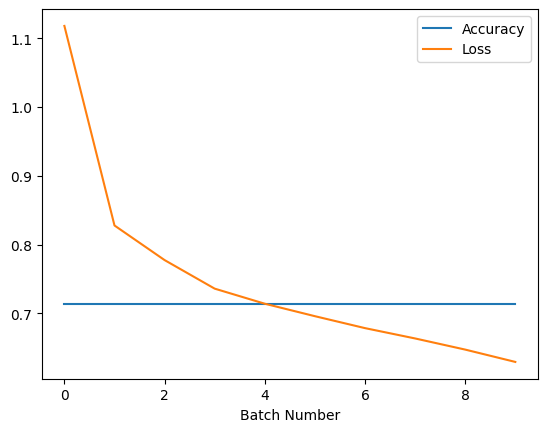

In [30]:
creditNeuralNetwork = NeuralNetwork(11, 2, [3], 0.05, 1e-7)
creditNeuralNetwork.gradientDescent(trainingData, trainingLabels, 7, 10)

In [31]:
test = data[350:]

#Get the labels (stored in column 0) and store them in an array
testLabels = test[:, -1]
#Get the rest of the data
testData = test[:,:-1]
#Convert the integer values 0 - 255 to float values -1 - 1
testData = (testData.astype(np.float32))

In [32]:
output = creditNeuralNetwork.forward(testData)
predictions = creditNeuralNetwork.getPredictions(output)
accuracy = creditNeuralNetwork.getAccuracy(predictions, testLabels)
print("Accuracy on the test set:",accuracy)

Accuracy on the test set: 0.8


# Loan default classification

In [33]:
data = pd.read_csv('archive/Default_Fin.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = data.drop("Index", axis=1)

data["Bank Balance"] = data["Bank Balance"] / data["Bank Balance"].max()
data["Annual Salary"] = data["Annual Salary"] / data["Annual Salary"].max()

In [34]:
data = np.array(data)

data = data[1:] #remove column labels
np.random.default_rng().shuffle(data)

training = data[:9000]
#Get the labels (stored in column 0) and store them in an array
trainingLabels = training[:, -1].astype(np.int8)
#Get the rest of the data
trainingData = training[:,:-1]
#Convert the integer values 0 - 255 to float values 0 - 1
trainingData = (trainingData.astype(np.float32))

Starting epoch 0
Epoch: 0, Accuracy: 0.400, Loss: 0.793
Epoch: 0, Accuracy: 0.933, Loss: 0.188
Epoch: 0, Accuracy: 0.933, Loss: 0.237
Starting epoch 1
Epoch: 1, Accuracy: 0.900, Loss: 0.259
Epoch: 1, Accuracy: 0.933, Loss: 0.163
Epoch: 1, Accuracy: 0.933, Loss: 0.227
Starting epoch 2
Epoch: 2, Accuracy: 0.900, Loss: 0.224
Epoch: 2, Accuracy: 0.933, Loss: 0.143
Epoch: 2, Accuracy: 0.933, Loss: 0.211
Starting epoch 3
Epoch: 3, Accuracy: 0.900, Loss: 0.194
Epoch: 3, Accuracy: 0.933, Loss: 0.129
Epoch: 3, Accuracy: 0.933, Loss: 0.198
Starting epoch 4
Epoch: 4, Accuracy: 0.900, Loss: 0.171
Epoch: 4, Accuracy: 0.967, Loss: 0.120
Epoch: 4, Accuracy: 0.933, Loss: 0.187
Starting epoch 5
Epoch: 5, Accuracy: 0.900, Loss: 0.154
Epoch: 5, Accuracy: 0.967, Loss: 0.114
Epoch: 5, Accuracy: 0.933, Loss: 0.179
Starting epoch 6
Epoch: 6, Accuracy: 0.900, Loss: 0.140
Epoch: 6, Accuracy: 0.967, Loss: 0.111
Epoch: 6, Accuracy: 0.933, Loss: 0.172
Starting epoch 7
Epoch: 7, Accuracy: 0.933, Loss: 0.130
Epoch:

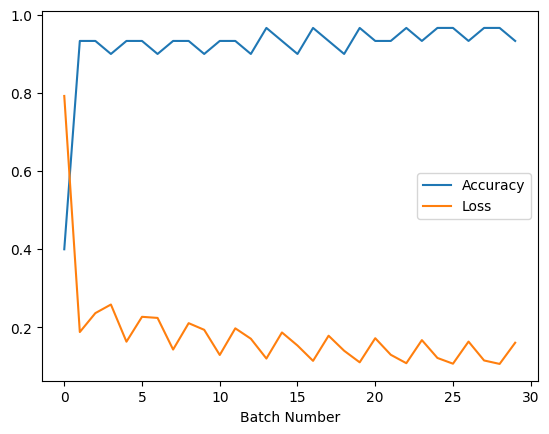

In [35]:
defaultNeuralNetwork = NeuralNetwork(3, 2, [2], 0.05, 1e-7)
defaultNeuralNetwork.gradientDescent(trainingData, trainingLabels, 30, 10)

In [36]:
test = data[9000:]

#Get the labels (stored in column 0) and store them in an array
testLabels = test[:, -1]
#Get the rest of the data
testData = test[:,:-1]
#Convert the integer values 0 - 255 to float values -1 - 1
testData = (testData.astype(np.float32))

In [37]:
output = defaultNeuralNetwork.forward(testData)
predictions = defaultNeuralNetwork.getPredictions(output)
accuracy = defaultNeuralNetwork.getAccuracy(predictions, testLabels)
print("Accuracy on the test set:",accuracy)

Accuracy on the test set: 0.965965965965966


# Loan default classification (large data set)

In [38]:
data = pd.read_csv('archive/Loan_default.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = data.drop("LoanID", axis=1)

columnsToNormalise = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]

for column in columnsToNormalise:
    data[column] = data[column] - data[column].min()
    data[column] = data[column] / data[column].max()

data["Education"] = data["Education"].map({"High School": 0, "Bachelor's": 0.33, "Master's": 0.66, "PhD":1})
data["EmploymentType"] = data["EmploymentType"].map({"Unemployed": 0, "Part-time": 0.33, "Self-employed": 0.66, "Full-time":1})
data["MaritalStatus"] = data["MaritalStatus"].map({"Divorced": 0, "Single": 0.5, "Married": 1})
data["HasMortgage"] = data["HasMortgage"].map({"No": 0, "Yes": 1})
data["HasDependents"] = data["HasDependents"].map({"No": 0, "Yes": 1})
data["LoanPurpose"] = data["LoanPurpose"].map({"Other": 0, "Auto": 0.25, "Business": 0.5, "Home": 0.75, "Education": 1})
data["HasCoSigner"] = data["HasCoSigner"].map({"No": 0, "Yes": 1})

In [39]:
data = np.array(data)

data = data[1:] #remove column labels
np.random.default_rng().shuffle(data)

training = data[:200000]
#Get the labels (stored in column 0) and store them in an array
trainingLabels = training[:, -1].astype(np.int8)
#Get the rest of the data
trainingData = training[:,:-1]
#Convert the integer values 0 - 255 to float values 0 - 1
trainingData = (trainingData.astype(np.float32))

Starting epoch 0
Epoch: 0, Accuracy: 0.130, Loss: 2.411
Epoch: 0, Accuracy: 0.865, Loss: 0.414
Epoch: 0, Accuracy: 0.905, Loss: 0.346
Epoch: 0, Accuracy: 0.890, Loss: 0.385
Epoch: 0, Accuracy: 0.885, Loss: 0.358
Epoch: 0, Accuracy: 0.905, Loss: 0.317
Epoch: 0, Accuracy: 0.875, Loss: 0.362
Epoch: 0, Accuracy: 0.880, Loss: 0.369
Epoch: 0, Accuracy: 0.890, Loss: 0.316
Epoch: 0, Accuracy: 0.915, Loss: 0.294
Starting epoch 1
Epoch: 1, Accuracy: 0.880, Loss: 0.372
Epoch: 1, Accuracy: 0.865, Loss: 0.396
Epoch: 1, Accuracy: 0.905, Loss: 0.322
Epoch: 1, Accuracy: 0.890, Loss: 0.361
Epoch: 1, Accuracy: 0.885, Loss: 0.344
Epoch: 1, Accuracy: 0.905, Loss: 0.302
Epoch: 1, Accuracy: 0.875, Loss: 0.355
Epoch: 1, Accuracy: 0.880, Loss: 0.361
Epoch: 1, Accuracy: 0.890, Loss: 0.311
Epoch: 1, Accuracy: 0.915, Loss: 0.290
Starting epoch 2
Epoch: 2, Accuracy: 0.880, Loss: 0.366
Epoch: 2, Accuracy: 0.865, Loss: 0.391
Epoch: 2, Accuracy: 0.905, Loss: 0.319
Epoch: 2, Accuracy: 0.890, Loss: 0.355
Epoch: 2, Acc

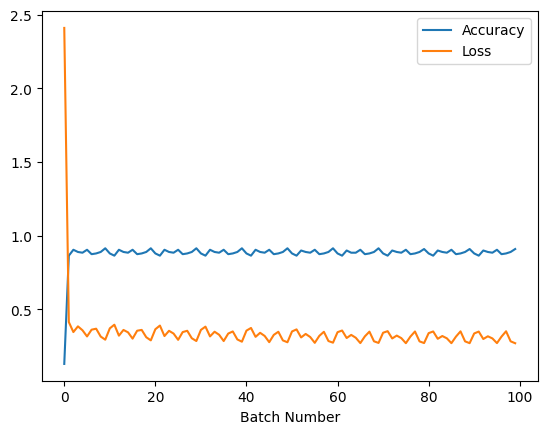

In [40]:
loanNeuralNetwork = NeuralNetwork(16, 2, [5, 5], 0.05, 1e-7)
loanNeuralNetwork.gradientDescent(trainingData, trainingLabels, 200, 10)

In [41]:
test = data[200000:210000]
#Get the labels (stored in column 0) and store them in an array
testLabels = test[:, -1]
#Get the rest of the data
testData = test[:,:-1]
#Convert the integer values 0 - 255 to float values 0 - 1
testData = (testData.astype(np.float32))

In [42]:
output = loanNeuralNetwork.forward(testData)
predictions = loanNeuralNetwork.getPredictions(output)
accuracy = loanNeuralNetwork.getAccuracy(predictions, testLabels)
print("Accuracy on the test set:",accuracy)

Accuracy on the test set: 0.8841
